In [238]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as k
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Lambda, LSTM, Dropout, BatchNormalization, Activation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Functions

 ## dataset loading

In [239]:
# load authors texts into dataframe
# folder paths should contain txt files containing articles written by each other
# left path specifics primary author to verify
# right path specifics other author or authors
def load_data_from_folder(path_left, path_right):
    df = pd.DataFrame(columns=['text', 'sequence', 'path'])
    
    for file in os.listdir(path_left):
        with open(os.path.join(path_left, file), 'r') as f:
            text = f.read()
        df.loc[len(df)] = [text, None, 'left']
        
    left_len = df.shape[0]
        
    for file in os.listdir(path_right):
        with open(os.path.join(path_right, file), 'r') as f:
            text = f.read()
        df.loc[len(df)] = [text, None, 'right']
    
    right_len = df.shape[0] - left_len
    
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(df['text'])
    df.loc[:, 'sequence'] = tokenizer.texts_to_sequences(df['text'])
        
    return df, left_len, right_len

In [240]:
# loads author texts into dataframe
# csv format: "id","text","author" with headers
# csv file should include authors 0 and 1 for left and right paths
def load_data_from_csv(csv_path, size):
    csv_df = pd.read_csv(csv_path)
    
    # left_len = len(csv_df.query('author == 0'))
    # right_len = len(csv_df.query('author == 1'))
    
    df = pd.concat([csv_df.query('author == 0').sample(n=size)], ignore_index=True)
    df = pd.concat([df, csv_df.query('author == 1').sample(n=size)], ignore_index=True)
    df = df.drop(columns=['id'])
    df.rename(columns={'author':'path'} , inplace=True)
    df['path'] = df['path'].replace({0:"left", 1:"right"})
        
    df.insert(1, 'sequence', None)
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(df['text'])
    df.loc[:, 'sequence'] = np.asarray(tokenizer.texts_to_sequences(df['text']), dtype='object')
    
    return df, size, size

## dataset manipulation

In [241]:
# create paired data with sequence1 sequence2 label columns
# df needs to contain sequence and path columns
# it will be half the size of one author dataset
# and will contain half rows with same author articles
# and other half rows with different author articles
def create_paired_data(df, size):
    quarter_left_size = size // 4
    paired_df = pd.DataFrame(columns=['sequence1', 'sequence2', 'label'])
    
    # set sequences to all left-path articles
    paired_df['sequence1'] = df.query('path == "left"').sample(frac=0.5, ignore_index=True)['sequence']
    paired_df['sequence2'] = df.query('path == "left"').sample(frac=0.5, ignore_index=True)['sequence']
    
    # set the second half of sequence2 to right-path articles
    paired_df.loc[quarter_left_size:, 'sequence2'] = df.query('path == "right"').sample(frac=0.5, ignore_index=True)['sequence']
    
    # set label data
    paired_df.loc[0:quarter_left_size, 'label'] = 1
    paired_df.loc[quarter_left_size:, 'label'] = 0
    
    return paired_df

In [242]:
# splits paired dataframe into train and test splits
# train_frac determines what percentage of data will go to the training set
# the rest goes to testing set
def create_split_data(paired_df, train_frac):
    train_df = paired_df.sample(frac=train_frac)
    train_df.reset_index(drop=True, inplace=True)

    test_df = paired_df.sample(frac=(1-train_frac))
    test_df.reset_index(drop=True, inplace=True)
    
    return train_df, test_df

In [243]:
# create model input ndarrays from train/test dataframes
# seq_len determines the length of each final sequence
# texts shorter than seq_len will be padded
# texts longer than seq_len will be truncated
# outputs can be used directly on model
def create_input_data(train_df, test_df, seq_len):
    train_left = np.zeros(shape=(len(train_df), seq_len))
    for i in range(len(train_df)):
        for j in range(len(train_df.sequence1[i])):
            if j < seq_len:
                train_left[i][j] = train_df.sequence1[i][j]
            else:
                break
                
    train_right = np.zeros(shape=(len(train_df), seq_len))
    for i in range(len(train_df)):
        for j in range(len(train_df.sequence2[i])):
            if j < seq_len:
                train_right[i][j] = train_df.sequence2[i][j]
            else:
                break
                
    test_left = np.zeros(shape=(len(test_df), seq_len))
    for i in range(len(test_df)):
        for j in range(len(test_df.sequence1[i])):
            if j < seq_len:
                test_left[i][j] = test_df.sequence1[i][j]
            else:
                break
                
    test_right = np.zeros(shape=(len(test_df), seq_len))
    for i in range(len(test_df)):
        for j in range(len(test_df.sequence2[i])):
            if j < seq_len:
                test_right[i][j] = test_df.sequence2[i][j]
            else:
                break
                
    labels_train = np.zeros(shape=(len(train_df)))
    for i in range(len(train_df)):
        labels_train[i] = train_df.label[i]
        
    labels_test = np.zeros(shape=(len(test_df)))
    for i in range(len(test_df)):
        labels_test[i] = test_df.label[i]
        
    return train_left, train_right, test_left, test_right, labels_train, labels_test

## print statistics

In [244]:
def print_history_plot(hist, epo_num):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['loss'])
    plt.axis([0, epo_num, 0, 1])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Accuracy','loss'], loc='lower left')
    plt.show()

In [245]:
def print_confusion_matrix(model, x_test_left, x_test_right, y_test):
    pred = model.predict([x_test_left, x_test_right])
    for i in range(len(pred)):
        if pred[i] > 0.5:
            pred[i] = 1
        else:
            pred[i] = 0
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## learning model

In [246]:
# euclidean distance between two sequence vectors
# from: https://github.com/FernandoLpz/AuthorVerificiation/tree/master
def euclidean_distance(vects):
	x, y = vects
	return k.sqrt(k.maximum(k.sum(k.square(x - y), axis=1, keepdims=True), k.epsilon()))

In [247]:
# returns shapes for euclidean distances
# from: https://github.com/FernandoLpz/AuthorVerificiation/tree/master
def eucl_dist_output_shape(shapes):
	shape1, shape2 = shapes	
	return shape1[0], 1

In [248]:
# single neural network model for siamese architecture
# from: https://github.com/FernandoLpz/AuthorVerificiation/tree/master
# slightly edited for input size
def siamese_architecture(input_size):
    single_model = Sequential()
    single_model.add(Conv1D(filters=75, kernel_size=12, padding='same', activation='relu'))
    single_model.add(BatchNormalization())
    single_model.add(Activation('relu'))
    single_model.add(Dropout(0.1))
    single_model.add(Conv1D(50, 12))
    single_model.add(Activation('relu'))
    single_model.add(BatchNormalization())
    single_model.add(Dropout(0.1))
    single_model.add(MaxPooling1D(4))
    single_model.add(LSTM(64, recurrent_dropout=0.1, return_sequences=False))
    single_model.add(Activation('relu'))
    single_model.build(input_shape=(None, input_size, 1))
    return single_model

In [249]:
# full siamese model using two neural networks
# from: https://github.com/FernandoLpz/AuthorVerificiation/tree/master
def siamese_model(seq_len):
    single_model = siamese_architecture(seq_len)
    input1 = Input(shape=(seq_len, 1))
    input2 = Input(shape=(seq_len, 1))
    left_branch = single_model(input1)
    right_branch = single_model(input2)
    distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([left_branch, right_branch])
    full_model = Model(inputs=[input1, input2], outputs=distance)
    full_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return full_model

# Program

## Parameters

In [250]:
# parameters
sequence_len = 500          # length of each text sequence
batch_size = 16             # batch size for training
epochs_num = 16             # number of epochs to train on
train_frac_size = 0.7       # fraction of data to use for training set

## data setup

In [251]:
# load data
dataframe, left_size, right_size = load_data_from_folder('./data/AaronPressman', './data/EdnaFernandes')
# dataframe, left_size, right_size = load_data_from_csv('./data/spooky_dataset.csv', 300)

# print data as loaded
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(dataframe)

,text,sequence,path
0,"""It is done it is most cheerfully agreed.","[10, 22, 235, 10, 22, 91, 791, 792]",left
1,"The balloon at first collapsed, then furiously...","[1, 17, 74, 62, 62, 392, 3, 392, 13, 319, 3, 3...",left
2,For arms there dangled from the upper portion ...,"[20, 524, 34, 23, 1, 395, 2, 1, 96, 76, 13, 1,...",left
3,"""In supposing it to be a bug of real gold.""","[6, 10, 5, 25, 4, 525, 2, 274, 526]",left
4,What of it there remained I will not attempt t...,"[55, 2, 10, 34, 275, 7, 70, 21, 800, 5, 527, 3...",left
5,"""The poem over the signature 'Snob' is, we fin...","[1, 75, 1, 22, 38, 528, 801, 3, 38, 58, 5, 104...",left
6,End of Text Notes to Hans Pfaal NOTE Strictly ...,"[180, 2, 397, 5, 529, 802, 34, 22, 19, 82, 803...",left
7,"For wisdom, ask of the angels freely, that it ...","[20, 2, 1, 816, 9, 10, 117, 25, 204]",left
8,The apartments of the students were converted ...,"[1, 817, 2, 1, 26, 51, 35, 105, 537, 241, 3, 3...",left
9,"It was formed of a single, broad and thick pla...","[10, 8, 538, 2, 4, 325, 3, 818, 2, 1]",left


In [252]:
# pair text sequences of same/different authors
paired_dataframe = create_paired_data(dataframe, left_size)

# print paired texts and labels
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(paired_dataframe)

,sequence1,sequence2,label
0,"[7, 1, 666, 1, 2, 16, 478]","[1, 2, 1, 8, 63, 101, 5, 4, 590, 9, 1, 401, 17...",1
1,"[10, 8, 13, 9, 11, 15, 3, 703, 13, 1, 2, 225]","[5, 16, 397]",1
2,"[7, 4, 32, 96, 23, 54, 38, 58, 9, 98, 43, 27, ...","[180, 2, 397, 5, 529, 802, 34, 22, 19, 82, 803...",1
3,"[1, 561, 78, 21, 859, 1, 860, 562, 2, 125, 43,...","[4, 22, 45, 54]",1
4,"[2, 88, 22, 42, 15, 630, 20, 15, 130]","[6, 332, 149, 41, 93, 25, 36, 554, 36, 333, 49...",1
5,"[4, 31, 3, 7, 1, 17, 4]","[3, 53, 951, 3, 951, 342, 1, 13, 4, 9, 142, 31...",1
6,"[4, 4, 4, 4, 57]","[34, 8, 33, 6, 65, 2, 1]",1
7,"[17, 115, 6, 660, 47, 962, 7, 139, 40, 661, 2,...","[1, 2, 1, 8, 93, 297, 182, 24, 4, 18, 10, 3, 1...",1
8,"[55, 22, 1, 610, 2, 30, 29, 7, 611]","[1, 565, 26, 161, 6, 937, 3, 6, 938, 3, 605, 5...",1
9,"[3, 136, 26, 4, 2, 3, 675]","[1, 58, 3, 662, 3, 28, 21, 61, 73, 3, 75, 1, 6...",1


In [253]:
# split train and test sets
train_dataframe, test_dataframe = create_split_data(paired_dataframe, train_frac_size)

# display train and test sets
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(train_dataframe)
    display(test_dataframe)

,sequence1,sequence2,label
0,"[41, 21, 819, 55, 8, 77]","[10, 8, 1, 394, 2, 1, 19, 62, 109, 112, 412, 3...",1
1,"[10, 8, 538, 2, 4, 325, 3, 818, 2, 1]","[517, 259, 382, 5, 249, 4, 502, 2, 36, 49, 4, ...",0
2,"[17, 115, 6, 660, 47, 962, 7, 139, 40, 661, 2,...","[1, 2, 1, 8, 93, 297, 182, 24, 4, 18, 10, 3, 1...",1
3,"[32, 8, 10, 4, 2, 16, 828, 2, 9, 7, 87, 33, 42...","[14, 7, 143, 1, 440, 6, 3, 186, 52, 3, 5, 1, 7...",1
4,"[1, 248, 2, 4, 998, 41, 21, 629, 124]","[19, 11, 10, 102, 45, 11, 750, 113, 4, 315, 12...",0
5,"[1, 281, 22, 844, 48, 42, 4, 553, 19, 1, 282, ...","[96, 17, 81, 39, 5, 15, 239, 19, 59, 1, 41, 48...",0
6,"[7, 9, 7, 28, 169, 3, 310, 2, 1, 6, 18, 10, 22...","[392, 3, 392, 38, 21, 13, 65, 19, 6, 3, 9, 435...",1
7,"[11, 31, 165, 21, 5, 147, 65, 582, 419, 188, 1...","[10, 22, 767, 9, 398, 11, 35, 23, 1, 418, 2, 3...",0
8,"[1, 565, 26, 161, 6, 937, 3, 6, 938, 3, 605, 5...","[12, 1, 50, 259, 11, 642, 1, 155, 97, 11, 154,...",0
9,"[136, 18, 6, 1, 130, 22, 330, 22, 322, 6, 1]","[19, 11, 8, 66, 3, 15, 237, 14, 11, 257, 7, 28...",0


,sequence1,sequence2,label
0,"[6, 461, 38, 1, 66, 288, 13]","[11, 8, 62, 863, 313, 19, 11, 410, 309, 837, 1...",1
1,"[47, 94, 10, 14, 367, 14, 238, 913, 47, 14, 76...","[3, 169, 266, 45, 1, 138, 7, 186, 51, 1, 366, ...",1
2,"[23, 5, 551, 21, 4, 138, 280, 6, 18, 11, 78, 2...","[17, 74, 7, 8, 106, 83, 5, 912]",1
3,"[32, 67, 11, 5, 44, 117, 25, 113, 42, 39, 13, ...","[37, 70, 284, 25, 35, 14, 21, 5, 88, 6, 73, 24...",1
4,"[55, 72, 28, 43, 1, 593, 2, 30, 62, 45, 125, 2...","[7, 12, 43, 109, 555, 362, 932, 27, 16, 3, 9, ...",0
5,"[1, 57, 2, 216, 8, 21, 5, 221, 27, 102, 3, 8, ...","[9, 57, 991, 423, 12, 43, 85, 1, 2, 1, 132, 53...",0
6,"[1, 374, 9, 81, 1, 116, 12, 43, 404, 21, 425, ...","[36, 721, 39, 14, 7, 49, 7, 233, 446, 222, 77,...",0
7,"[34, 22, 19, 46, 849, 2, 42, 1, 247, 3, 9, 849...","[164, 1, 340, 2, 84, 131, 197, 2, 413, 9, 769,...",0
8,"[41, 21, 819, 55, 8, 77]","[10, 8, 1, 394, 2, 1, 19, 62, 109, 112, 412, 3...",1
9,"[42, 16, 598, 17, 144, 599, 927, 3, 600, 243, ...","[34, 26, 27, 1, 96, 952, 412, 5, 687, 3, 86, 7...",0


## running the model

Epoch 1/16
7/7 [==============================] - 12s 210ms/step - loss: 0.3247 - accuracy: 0.4952
Epoch 2/16
7/7 [==============================] - 1s 199ms/step - loss: 0.2587 - accuracy: 0.4857
Epoch 3/16
7/7 [==============================] - 1s 177ms/step - loss: 0.2615 - accuracy: 0.5048
Epoch 4/16
7/7 [==============================] - 1s 175ms/step - loss: 0.2644 - accuracy: 0.5333
Epoch 5/16
7/7 [==============================] - 1s 175ms/step - loss: 0.2612 - accuracy: 0.5238
Epoch 6/16
7/7 [==============================] - 1s 178ms/step - loss: 0.2617 - accuracy: 0.4952
Epoch 7/16
7/7 [==============================] - 1s 177ms/step - loss: 0.2522 - accuracy: 0.5905
Epoch 8/16
7/7 [==============================] - 1s 176ms/step - loss: 0.2470 - accuracy: 0.5333
Epoch 9/16
7/7 [==============================] - 1s 177ms/step - loss: 0.2596 - accuracy: 0.4667
Epoch 10/16
7/7 [==============================] - 1s 177ms/step - loss: 0.2632 - accuracy: 0.3905
Epoch 11/16
7/7 [=

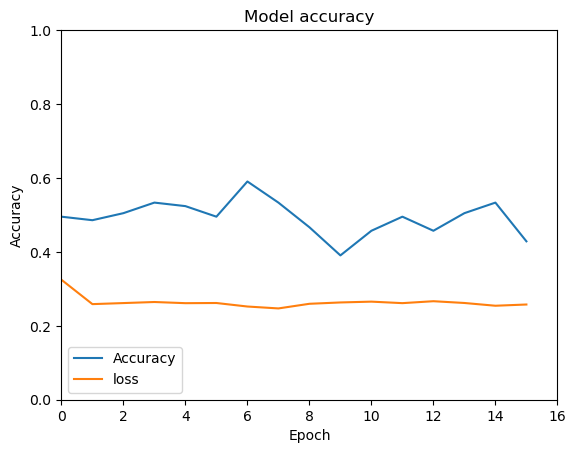

In [254]:
# create neural network input arrays
x_train_left, x_train_right, x_test_left, x_test_right, y_train, y_test = create_input_data(train_dataframe, test_dataframe, sequence_len)

# create model
model = siamese_model(sequence_len)

# train model
history = model.fit(x=[x_train_left, x_train_right], y=y_train, epochs=epochs_num, batch_size=batch_size)

# print history plot
print_history_plot(history, epochs_num)

2/2 [==============================] - 1s 39ms/step


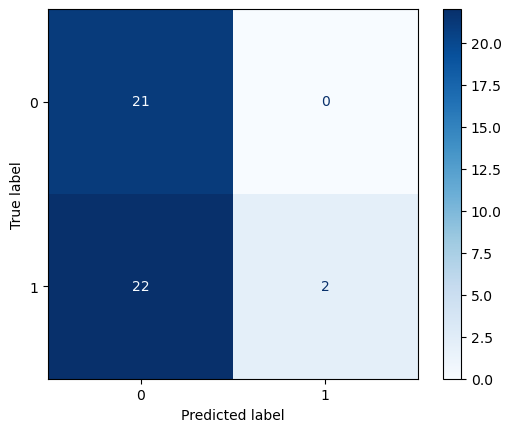

In [255]:
print_confusion_matrix(model, x_test_left, x_test_right, y_test)